## 🛹 Graph Neural Network Playground

### GCN on the CORA dataset with PyTorch Geometric  

In [1]:
import os
import time
import random
import wandb

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# https://pyg.org/
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: watchstep (watchstep_). Use `wandb login --relogin` to force relogin


True

In [3]:
# initializing Wanb
run = wandb.init(project='gcn-playground', tags=['CORA', 'pyg'], reinit=True)

def show_wandb_img(graph, color, epoch=None, loss=None):
  plt.figure(figsize=(5, 5))
  plt.xticks([])
  plt.yticks([])
  
  if torch.is_tensor(graph):
    graph = graph.detach().cpu().numpy()
    plt.scatter(graph[:, 0], graph[:, 1], cmap='Set1', c=color, s=80)
    if epoch != None and loss != None:
      plt.xlabel(f'Epoch: {epoch} | Loss: {loss.item():.4f}', fontsize=12)
  else:
    nx.draw_networkx(graph, pos=nx.spring_layout(graph, seed=42), with_labels=False, 
                     cmap='Set1', node_color=color, node_size=70, linewidths=5)
  
  wandb_img = wandb.Image(plt)
  plt.show();
  return wandb_img

### 1. Prepare Data

#### Load the CORA dataset

In [4]:
wandb.config.dataset = 'CORA'

cora_dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
print(f'Dataset: {cora_dataset}')
print(f'===================')
print(f'# of graphs: {len(cora_dataset)}')
print(f'# of features: {cora_dataset.num_features}')
print(f'# of classes: {cora_dataset.num_classes}') # node classification

Dataset: Cora()
# of graphs: 1
# of features: 1433
# of classes: 7


- Only One Graph
- 1433-dim feature vector
- 7 classes

In [5]:
# first graph (Only one graph in the CORA dataset)
data = cora_dataset[0]

print(data) 
print('===========================================================================================================')
print(f'Undirected Graph: {data.is_undirected()}')
print(f'classes: {np.unique(data.y)}')
print(f'# of nodes: {data.num_nodes}')
print(f'# of edges: {data.num_edges}')
print(f'AVG node degree: {data.num_edges / data.num_nodes: .1f}')
print(f'# of train nodes: {data.train_mask.sum()}')
print(f'train node labeling rate: {data.train_mask.sum() / data.num_nodes: .2f}')
print(f'# of val nodes: {data.val_mask.sum()}')
print(f'# of test nodes: {data.test_mask.sum()}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'hans self-loops: {data.has_self_loops()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Undirected Graph: True
classes: [0 1 2 3 4 5 6]
# of nodes: 2708
# of edges: 10556
AVG node degree:  3.9
# of train nodes: 140
train node labeling rate:  0.05
# of val nodes: 500
# of test nodes: 1000
has isolated nodes: False
hans self-loops: False


- `edge_index`: graph connectivity  
(node index of the soruce node, node index of the destination node of an edge)
- `x` (node features): each of the 2708 nodes is assigned a 1433-dim feature vector
- `y` (node labels): each node is assigned to exactly one class
- isolated nodes: there exists no edge to any node
- self-loops: $(v, v) \in \mathcal{E}$

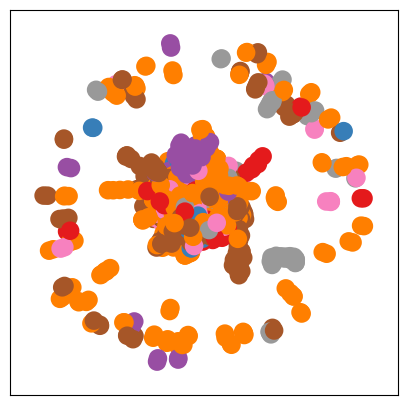

In [6]:
G = pyg_utils.to_networkx(data, to_undirected=True)
wandb_img = show_wandb_img(G, color=data.y)
wandb.log({'CORA Network': wandb_img},)

### 2. GCN layers

In [7]:
from torch_geometric.nn import GCNConv

# Semi-Supervised Node Classification
class GCN(torch.nn.Module):
  def __init__(self, input_dim:int, hidden_dim:int, output_dim:int, num_layers:int, dropout:float):
    super().__init__()
    self.convs = torch.nn.ModuleList()
    self.convs.append(GCNConv(input_dim, hidden_dim))
    self.dropout = dropout
    self.num_layers = num_layers
    
    # Create GCN layers
    assert (self.num_layers >= 1), "# of layers should >= 1"
    for i in range(self.num_layers-1):
      self.convs.append(GCNConv(hidden_dim, hidden_dim))
      
    # post-message-passing processing
    self.lin1 = nn.Linear(hidden_dim, hidden_dim)
    self.lin2 = nn.Linear(hidden_dim, output_dim)
    self.post_mp = nn.Sequential(
      self.lin1,
      nn.Dropout(self.dropout),
      self.lin2)
  
  def reset_parameters(self):
    self.conv1.reset_parameters()
    for conv in self.convs:
      conv.reset_parameters()
    self.lin1.reset_parameters()
    self.lin2.reset_parameters()


  def forward(self, x, edge_index):
    # x : node feature matrix
    # edge_index : graph connectivity matirx
    for i in range(self.num_layers):
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    
    graph = x
    # Sequential
    x = self.post_mp(x)
    
    # log_softmax & NLL loss instead of softmax output & cross entropy loss
    # for performance & numerical stability
    return F.log_softmax(x, dim=1), graph

### 3. Training & Evaluating

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'DEVICE: {device}')

wandb.config.seed = 42
wandb.config.conv_model = 'GCNConv'
wandb.config.num_layers = 3
wandb.config.hidden_dim = 34
wandb.config.non_linearity = 'relu'
wandb.config.is_cuda = torch.cuda.is_available()

input_dim = cora_dataset.num_features
output_dim = cora_dataset.num_classes

model = GCN(input_dim=input_dim, hidden_dim=34, output_dim=output_dim, num_layers=3, dropout=0.25).to(device)
print(model)

# data = cora_dataset[0]
data = data.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

DEVICE: cpu
GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 34)
    (1): GCNConv(34, 34)
    (2): GCNConv(34, 34)
  )
  (lin1): Linear(in_features=34, out_features=34, bias=True)
  (lin2): Linear(in_features=34, out_features=7, bias=True)
  (post_mp): Sequential(
    (0): Linear(in_features=34, out_features=34, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=34, out_features=7, bias=True)
  )
)


Embedding shape: [2708, 34]


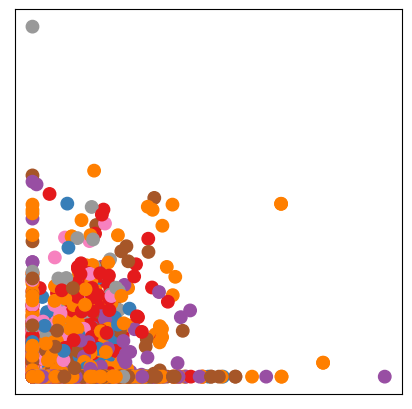

In [9]:
_, graph = model(data.x, data.edge_index)
print(f'Embedding shape: {list(graph.shape)}')

wandb_img = show_wandb_img(graph, color=data.y)
wandb.log({'node embedding before training': wandb_img})

In [10]:
wandb.config.epoch = 1001

def train():
  model.train()
  for epoch in range(1001):
    optimizer.zero_grad()
    out, graph = model(data.x, data.edge_index)
    # compute loss
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # NlL loss
    loss.backward()
    # update parametesrs based on gradients
    optimizer.step()
    
    if epoch % 100 == 0:
      wandb_img = show_wandb_img(graph, color=data.y, epoch=epoch, loss=loss)
      time.sleep(0.5)
      wandb.log({"node embedding while training": wandb_img},)
      
    wandb.log({'loss': loss})

In [11]:
def eval(is_val=False):
  model.eval()
  with torch.no_grad():
    pred, graph = model(data.x, data.edge_index)
    pred = pred.argmax(dim=1)
    mask = data.val_mask if is_val else data.test_mask
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    
    wandb.img = show_wandb_img(graph, color=data.y)
    wandb.log({"node embedding while testing": wandb_img},)
  print(f'ACC: {acc:.4f}')

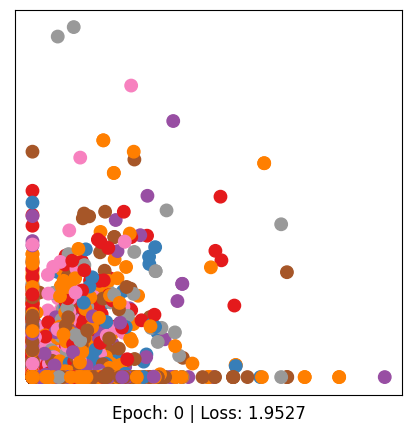

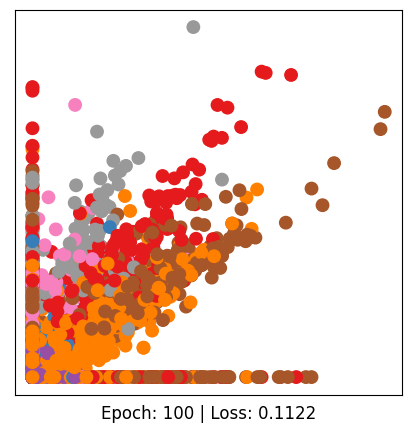

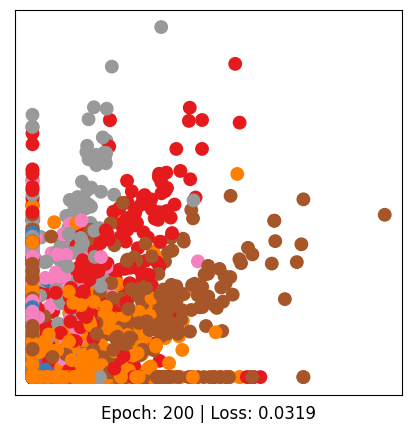

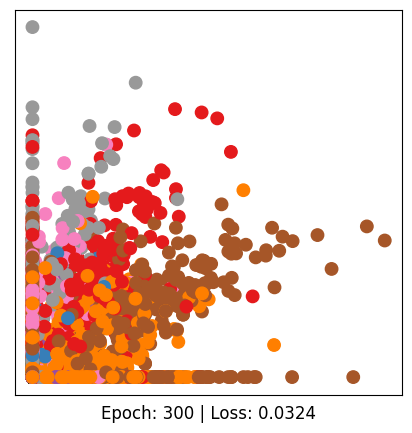

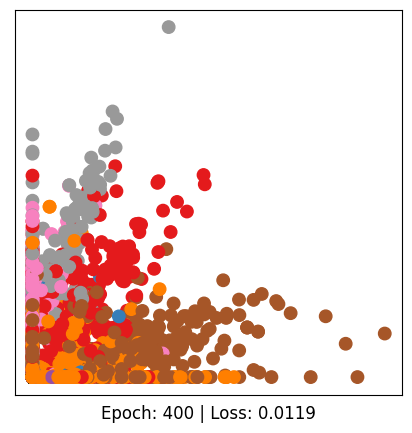

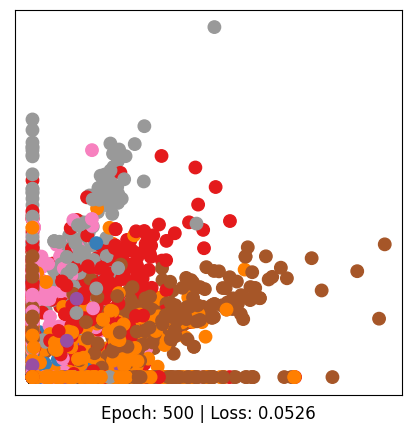

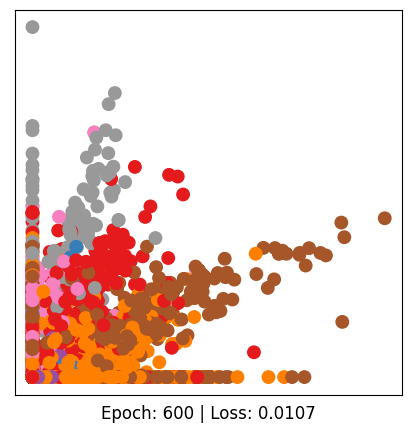

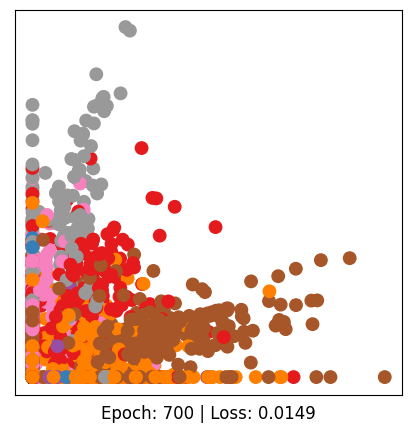

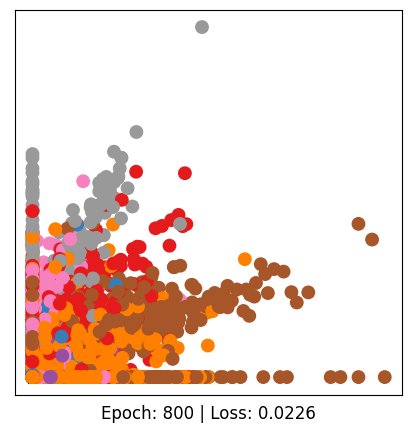

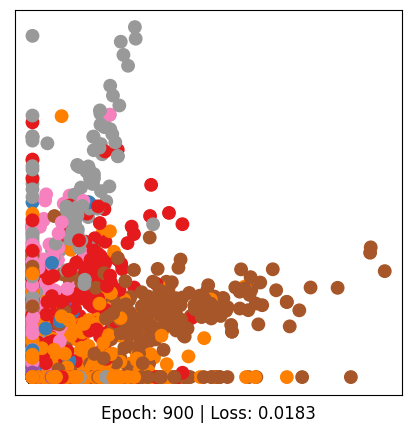

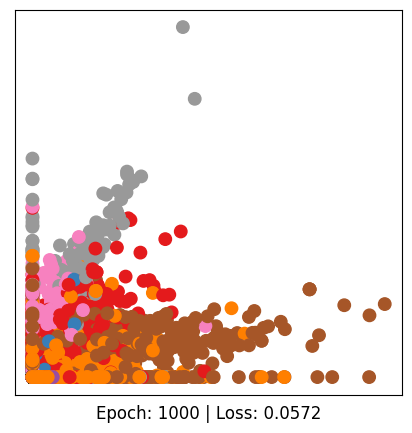

In [12]:
train()

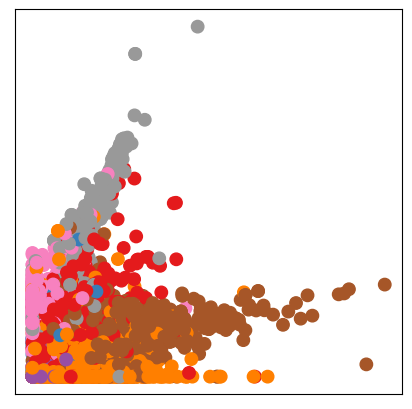

ACC: 0.7220


In [13]:
eval()

### Finish

In [14]:
run.finish()

loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.05721
